In [1]:
import os
import glob

base_dir = os.path.join('../input/cell-images-for-detecting-malaria/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)



(13779, 13779)

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

print(len(files_df))

27558


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

# Output
#(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627})
Val: Counter({'healthy': 970, 'malaria': 959})
Test: Counter({'malaria': 4193, 'healthy': 4075})


(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [4]:
Counter(train_labels)

Counter({'malaria': 8627, 'healthy': 8734})

In [5]:
import cv2
from concurrent import futures
import threading
IMG_DIMS = (100 ,100)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  



Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 5000
ThreadPoolExecutor-1_2: working on img num: 10000
ThreadPoolExecutor-1_3: working on img num: 15000
ThreadPoolExecutor-1_6: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_2: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_1: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 5000
ThreadPoolExecutor-1_7: working on img num: 8267


((17361, 100, 100, 3), (1929, 100, 100, 3), (8268, 100, 100, 3))

In [6]:
del train_data_inp
del val_data_inp
del test_data_inp

In [7]:
del test_data_map
del train_data_map
del val_data_map

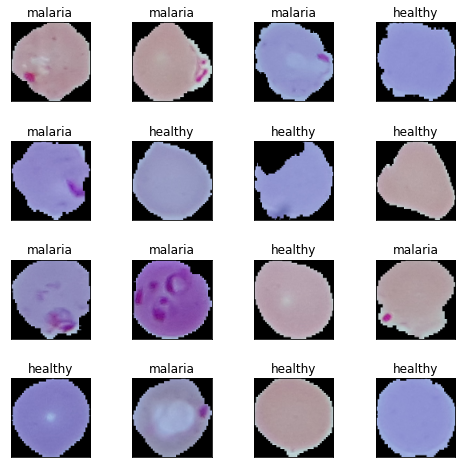

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (100, 100, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [10]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.random.set_seed(42)
tf.__version__


'2.4.1'

In [11]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = tf.keras.layers.Dropout(rate=0.3)(pool1)

conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = tf.keras.layers.Dropout(rate=0.3)(pool2)

conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = tf.keras.layers.Dropout(rate=0.3)(pool3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)        0     

In [12]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 25s 75ms/step - loss: 0.6812 - accuracy: 0.5847 - val_loss: 0.1792 - val_accuracy: 0.9450
Epoch 2/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1954 - accuracy: 0.9348 - val_loss: 0.1474 - val_accuracy: 0.9590
Epoch 3/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1490 - accuracy: 0.9542 - val_loss: 0.1320 - val_accuracy: 0.9601
Epoch 4/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1427 - accuracy: 0.9575 - val_loss: 0.1423 - val_accuracy: 0.9606
Epoch 5/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1276 - accuracy: 0.9592 - val_loss: 0.1385 - val_accuracy: 0.9606
Epoch 6/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1236 - accuracy: 0.9602 - val_loss: 0.1346 - val_accuracy: 0.9596
Epoch 7/25
272/272 [==============================] - 19s 70ms/step - loss: 0.1177 - accuracy: 0.9585 - val_loss: 0.1250 - val_accuracy:

In [13]:
model.save('basic_cnn.h5')


In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


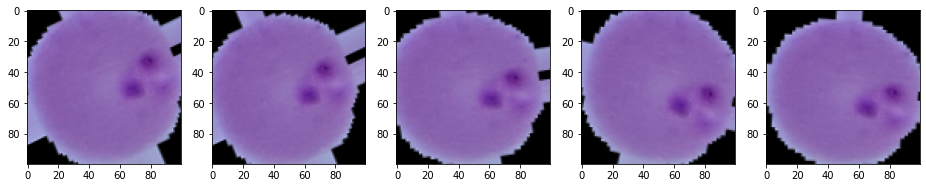

In [15]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]


In [16]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

80142336/80134624 [==============================] - 1s 0us/step
Total Layers: 28
Total trainable layers: 16


In [21]:
test_imgs_scaled = test_data / 255.

basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])



NameError: name 'classification_report' is not defined

In [22]:
del test_data

In [23]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, basic_cnn_pred_labels)
print(report)

              precision    recall  f1-score   support

     healthy       0.95      0.97      0.96      4075
     malaria       0.97      0.95      0.96      4193

    accuracy                           0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268

